In [1]:
import os
import sys

notebook_dir = os.getcwd()  # Get the current working directory of the notebook
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Adjust as needed
sys.path.insert(0, project_root)

In [12]:
from src.utils_func import *
from src.training import *
from src.model import *
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torchvision
import optuna
from torchvision import transforms, datasets
import random
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Download, combine, split, augment, and prepare the MNIST dataset

In [3]:
full_dataset = download_dataset()
images, labels = combine_images(full_dataset, 'random')
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = split_dataset(images, labels)
augmented_images = augment_dataset(train_images)

combined_train_images = train_images + augmented_images
combined_train_labels = train_labels + train_labels

In [4]:
train_loader, val_loader = prepare_data(combined_train_images, combined_train_labels, val_images, val_labels, 64)

### Plot 1 - Loss and Validation for optimal models given each of the 3 optimisers

In [5]:
# Train the model with the best hyperparameters

epochs = 40

# val_loss_value_adam, val_acc_value_adam, test_loss_value_adam, test_acc_value_adam, train_loss_value_adam, train_acc_value_adam, train_list_adam, val_list_adam, train_acc_list_adam, val_acc_list_adam, _, _, _ = FCNN_optimised_5_hyp('adam', 25, epochs, True)
# df_adam = pd.DataFrame({'train_loss': train_list_adam, 'val_loss': val_list_adam, 'train_acc': train_acc_list_adam, 'val_acc': val_acc_list_adam})
# df_adam.to_csv('adam_results.csv')


# val_loss_value_sgd, val_acc_value_sgd, test_loss_value_sgd, test_acc_value_sgd, train_loss_value_sgd, train_acc_value_sgd, train_list_sgd, val_list_sgd, train_acc_list_sgd, val_acc_list_sgd, _, _, _ = FCNN_optimised_5_hyp('sgd', 25, epochs, True)
# df_sgd = pd.DataFrame({'train_loss': train_list_sgd, 'val_loss': val_list_sgd, 'train_acc': train_acc_list_sgd, 'val_acc': val_acc_list_sgd})
# df_sgd.to_csv('sgd_results.csv')

# val_loss_value_rms, val_acc_value_rms, test_loss_value_rms, test_acc_value_rms, train_loss_value_rms, train_acc_value_rms, train_list_rms, val_list_rms, train_acc_list_rms, val_acc_list_rms, _, _, _ = FCNN_optimised_5_hyp('rmsprop', 25, epochs, True)
# df_rms = pd.DataFrame({'train_loss': train_list_rms, 'val_loss': val_list_rms, 'train_acc': train_acc_list_rms, 'val_acc': val_acc_list_rms})
# df_rms.to_csv('rms_results.csv')

In [6]:
train_list_adam = pd.read_csv('adam_results.csv')['train_loss']
val_list_adam = pd.read_csv('adam_results.csv')['val_loss']
train_acc_list_adam = pd.read_csv('adam_results.csv')['train_acc']
val_acc_list_adam = pd.read_csv('adam_results.csv')['val_acc']

train_list_sgd = pd.read_csv('sgd_results.csv')['train_loss']
val_list_sgd = pd.read_csv('sgd_results.csv')['val_loss']
train_acc_list_sgd = pd.read_csv('sgd_results.csv')['train_acc']
val_acc_list_sgd = pd.read_csv('sgd_results.csv')['val_acc']

train_list_rms = pd.read_csv('rms_results.csv')['train_loss']
val_list_rms = pd.read_csv('rms_results.csv')['val_loss']
train_acc_list_rms = pd.read_csv('rms_results.csv')['train_acc']
val_acc_list_rms = pd.read_csv('rms_results.csv')['val_acc']

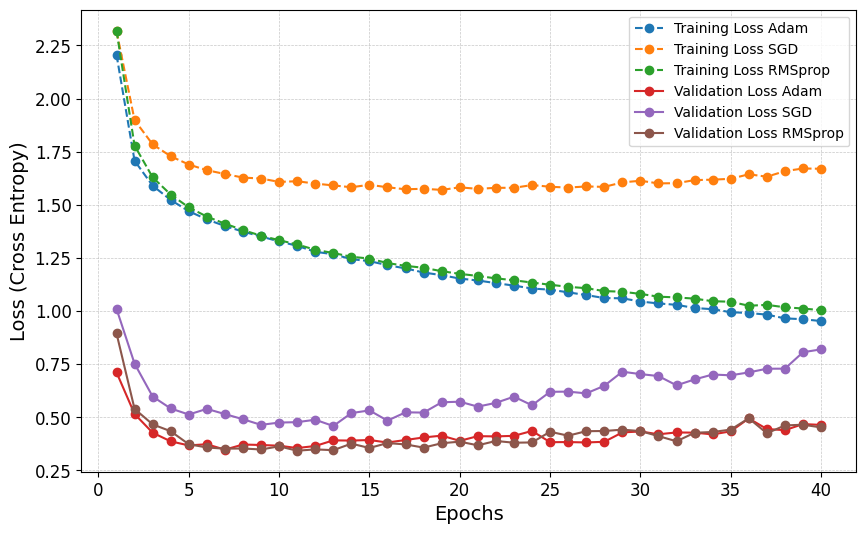

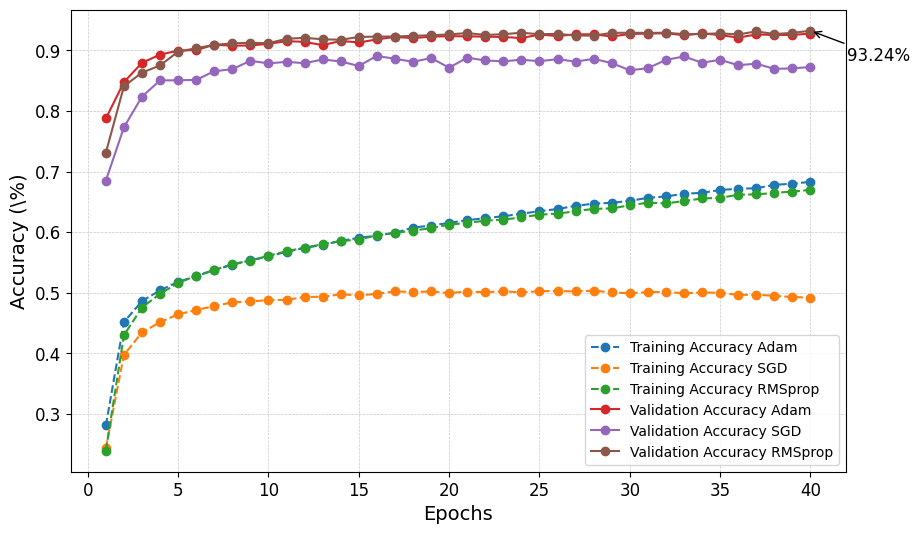

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(range(1,epochs+1), train_list_adam, label="Training Loss Adam", marker='o', linestyle='--')
plt.plot(range(1,epochs+1), train_list_sgd, label="Training Loss SGD", marker='o', linestyle='--')
plt.plot(range(1,epochs+1), train_list_rms, label="Training Loss RMSprop", marker='o', linestyle='--')
plt.plot(range(1,epochs+1), val_list_adam, label="Validation Loss Adam", marker='o')
plt.plot(range(1,epochs+1), val_list_sgd, label="Validation Loss SGD", marker='o')
plt.plot(range(1,epochs+1), val_list_rms, label="Validation Loss RMSprop", marker='o')
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss (Cross Entropy)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
# plt.savefig("Ultimate_loss.png", dpi=400, bbox_inches='tight')
plt.show()


best_epoch = list(val_acc_list_rms).index(max(val_acc_list_rms)) + 1  # Get the epoch (1-based index)
best_accuracy = max(val_acc_list_rms)



plt.figure(figsize=(10, 6))
plt.plot(range(1,epochs+1), train_acc_list_adam, label="Training Accuracy Adam", marker='o', linestyle='--')
plt.plot(range(1,epochs+1), train_acc_list_sgd, label="Training Accuracy SGD", marker='o', linestyle='--')
plt.plot(range(1,epochs+1), train_acc_list_rms, label="Training Accuracy RMSprop", marker='o', linestyle='--')
plt.plot(range(1,epochs+1), val_acc_list_adam, label="Validation Accuracy Adam", marker='o')
plt.plot(range(1,epochs+1), val_acc_list_sgd, label="Validation Accuracy SGD", marker='o')
plt.plot(range(1,epochs+1), val_acc_list_rms, label="Validation Accuracy RMSprop", marker='o')
plt.annotate(
    f"{best_accuracy*100:.2f}%",  # Format the value with two decimal places and add a percentage sign
    (best_epoch, best_accuracy),  # The point to annotate
    xytext=(best_epoch + 2, best_accuracy - 0.05),  # Annotation text position
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=12  # Optional: Adjust font size for better visibility
)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Accuracy (\%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
# plt.savefig("Ultimate_acc.png", dpi=400, bbox_inches='tight')
plt.show()

### Plot 2 - Depth/width NN

In [9]:
# Plot surface of validation loss against depth and width of NN

learning_rate_base = 0.005
batch_size_base = 64
activation_base = nn.ReLU()
dropout_rate_base = 0.2
no_epochs = 10
decay_factor_base = 1

num_hidden_layers = np.arange(0, 22, 2)
hidden_sizes = np.arange(50, 1500, 150)

# num_hidden_layers = [0, 2]
# hidden_sizes = [50, 200]


results = []

for num_hidden_layer in num_hidden_layers:
    for hidden_size in hidden_sizes:
        val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layer, hidden_size, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
        print(f"Layers: {num_hidden_layer}, Hidden: {hidden_size}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        results.append((num_hidden_layer, hidden_size, val_loss))
        print(f"Layers: {num_hidden_layer}, Hidden: {hidden_size}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(results, columns=['num_hidden_layers', 'hidden_size', 'val_loss'])
results_df.to_csv('nn_exp_results.csv', index=False)

Epoch 1/10
  Train Loss: 2.4321, Train Accuracy: 0.2011
  Val Loss: 1.5348, Val Accuracy: 0.4975
Epoch 2/10
  Train Loss: 2.2131, Train Accuracy: 0.2737
  Val Loss: 1.3483, Val Accuracy: 0.5589
Epoch 3/10
  Train Loss: 2.1643, Train Accuracy: 0.2926
  Val Loss: 1.3233, Val Accuracy: 0.5733
Epoch 4/10
  Train Loss: 2.1314, Train Accuracy: 0.3019
  Val Loss: 1.2624, Val Accuracy: 0.5942
Epoch 5/10
  Train Loss: 2.1082, Train Accuracy: 0.3110
  Val Loss: 1.2544, Val Accuracy: 0.5925
Epoch 6/10
  Train Loss: 2.0943, Train Accuracy: 0.3144
  Val Loss: 1.2208, Val Accuracy: 0.6163
Epoch 7/10
  Train Loss: 2.0849, Train Accuracy: 0.3183
  Val Loss: 1.2345, Val Accuracy: 0.6076
Epoch 8/10
  Train Loss: 2.0712, Train Accuracy: 0.3197
  Val Loss: 1.2058, Val Accuracy: 0.6227
Epoch 9/10
  Train Loss: 2.0636, Train Accuracy: 0.3232
  Val Loss: 1.2325, Val Accuracy: 0.6138
Epoch 10/10
  Train Loss: 2.0614, Train Accuracy: 0.3255
  Val Loss: 1.2183, Val Accuracy: 0.6114
Test Loss: 1.2095, Test Accur

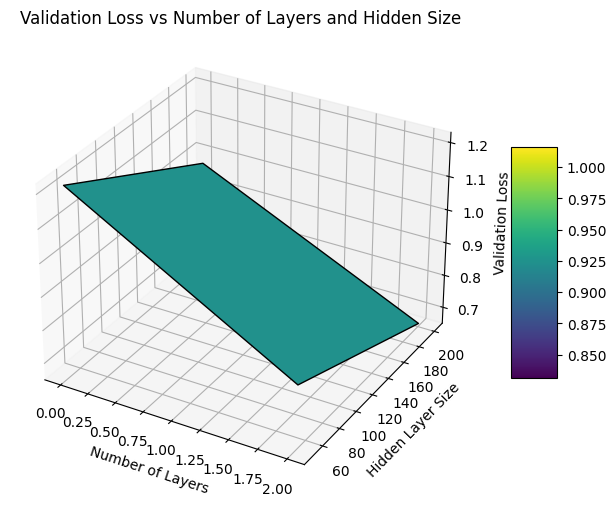

In [10]:
layers = np.array([r[0] for r in results])      # Number of layers (x-axis)
hidden_sizes = np.array([r[1] for r in results]) # Hidden size (y-axis)
val_losses = np.array([r[2] for r in results])   # Validation loss (z-axis)

# Reshape for plotting (if needed)
layers_grid = layers.reshape(len(num_hidden_layers), int(len(hidden_sizes)//len(num_hidden_layers)))
hidden_sizes_grid = hidden_sizes.reshape(len(num_hidden_layers), int(len(hidden_sizes)//len(num_hidden_layers)))
val_losses_grid = val_losses.reshape(len(num_hidden_layers), int(len(hidden_sizes)//len(num_hidden_layers)))


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(layers_grid, hidden_sizes_grid, val_losses_grid, cmap='viridis', edgecolor='k')

# Add labels
ax.set_xlabel("Number of Layers")
ax.set_ylabel("Hidden Layer Size")
ax.set_zlabel("Validation Loss")
ax.set_title("Validation Loss vs Number of Layers and Hidden Size")

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


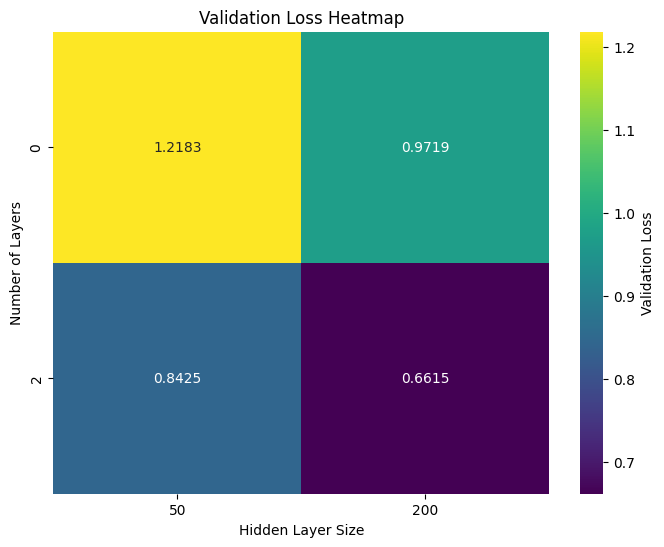

In [13]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=["num_hidden_layers", "hidden_size", "val_loss"])

# Pivot the DataFrame to create the heatmap-compatible format
heatmap_data = results_df.pivot(index="num_hidden_layers", columns="hidden_size", values="val_loss")



plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Validation Loss'})

# Add labels and title
plt.title("Validation Loss Heatmap")
plt.xlabel("Hidden Layer Size")
plt.ylabel("Number of Layers")
plt.show()

### Plot 3 - Effect of dropout rate on loss for different activation funcs

In [16]:
# Dropout rate against loss

learning_rate_base = 0.005
batch_size_base = 64
activation_base = nn.ReLU()
dropout_rate_base = 0.2
no_epochs = 10
num_hidden_layers_base = 3
hidden_size_base = 512
decay_factor_base = 0.7
dropout_rates = np.linspace(0, 0.8, 21)
# dropout_rates = [0, 0.2]

# activation function

val_losses_relu = []
train_losses_relu = []

val_losses_sigmoid = []
train_losses_sigmoid = []

for dropout_rate in dropout_rates:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_relu.append(val_loss)
    train_losses_relu.append(train_loss)
    print(f"Dropout Rate: {dropout_rate}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(list(zip(dropout_rates, val_losses_relu, train_losses_relu)), columns=["dropout_rate", "val_loss", "train_loss"])
results_df.to_csv('dropout_results_relu.csv', index=False)

activation_base = nn.Sigmoid()

for dropout_rate in dropout_rates:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_sigmoid.append(val_loss)
    train_losses_sigmoid.append(train_loss)
    print(f"Dropout Rate: {dropout_rate}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(list(zip(dropout_rates, val_losses_sigmoid, train_losses_sigmoid)), columns=["dropout_rate", "val_loss", "train_loss"])
results_df.to_csv('dropout_results_sigmoid.csv', index=False)


Epoch 1/10
  Train Loss: 2.1067, Train Accuracy: 0.3123
  Val Loss: 0.6849, Val Accuracy: 0.7936
Epoch 2/10
  Train Loss: 1.5979, Train Accuracy: 0.4791
  Val Loss: 0.4721, Val Accuracy: 0.8584
Epoch 3/10
  Train Loss: 1.4648, Train Accuracy: 0.5151
  Val Loss: 0.4467, Val Accuracy: 0.8676
Epoch 4/10
  Train Loss: 1.3770, Train Accuracy: 0.5431
  Val Loss: 0.3985, Val Accuracy: 0.8882
Epoch 5/10
  Train Loss: 1.3037, Train Accuracy: 0.5653
  Val Loss: 0.3947, Val Accuracy: 0.8915
Epoch 6/10
  Train Loss: 1.2395, Train Accuracy: 0.5871
  Val Loss: 0.4254, Val Accuracy: 0.8939
Epoch 7/10
  Train Loss: 1.1839, Train Accuracy: 0.6034
  Val Loss: 0.4300, Val Accuracy: 0.8943
Epoch 8/10
  Train Loss: 1.1280, Train Accuracy: 0.6225
  Val Loss: 0.4558, Val Accuracy: 0.8986
Epoch 9/10
  Train Loss: 1.0799, Train Accuracy: 0.6378
  Val Loss: 0.4820, Val Accuracy: 0.8954
Epoch 10/10
  Train Loss: 1.0334, Train Accuracy: 0.6532
  Val Loss: 0.4883, Val Accuracy: 0.9018
Test Loss: 0.5019, Test Accur

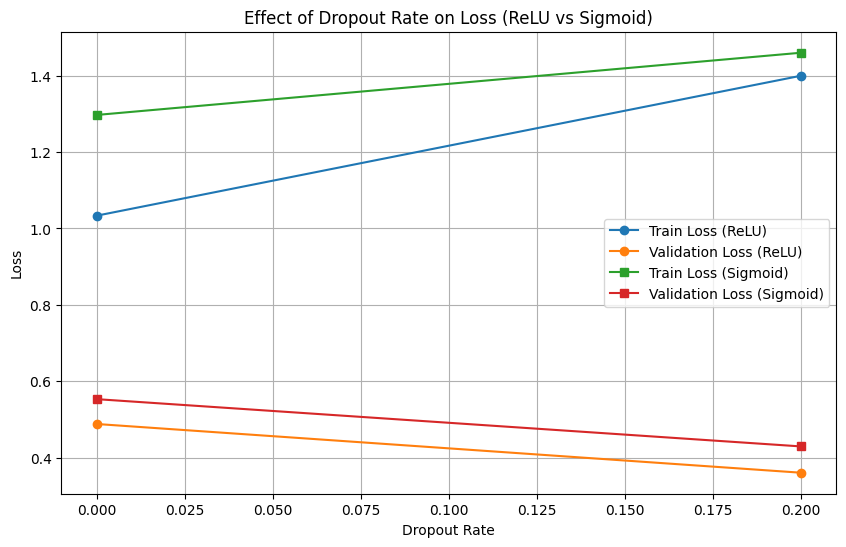

In [18]:
# Plot for ReLU
plt.figure(figsize=(10, 6))
plt.plot(dropout_rates, train_losses_relu, marker='o', label="Train Loss (ReLU)")
plt.plot(dropout_rates, val_losses_relu, marker='o', label="Validation Loss (ReLU)")

# Plot for Tanh
plt.plot(dropout_rates, train_losses_sigmoid, marker='s', label="Train Loss (Sigmoid)")
plt.plot(dropout_rates, val_losses_sigmoid, marker='s', label="Validation Loss (Sigmoid)")

# Labels and Title
plt.xlabel("Dropout Rate")
plt.ylabel("Loss")
plt.title("Effect of Dropout Rate on Loss (ReLU vs Sigmoid)")
plt.legend()
plt.grid(True)
plt.show()

### Plot 4 - Learning rate affects loss for different optimisers

In [19]:
# learning rate against loss for various optimisers

learning_rate = np.linspace(0.005, 0.5, 20)
batch_size_base = 64
activation_base = nn.ReLU()
optimisers = ['adam', 'sgd', 'rmsprop']
dropout_rate_base = 0.2
no_epochs = 10
num_hidden_layers_base = 3
hidden_size_base = 512
decay_factor_base = 0.7

val_losses_adam = []
train_losses_adam = []

val_losses_sgd = []
train_losses_sgd = []

val_losses_rmsprop = []
train_losses_rmsprop = []

for lr in learning_rate:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'rmsprop', no_epochs)
    val_losses_rmsprop.append(val_loss)
    train_losses_rmsprop.append(train_loss)
    print(f"Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(list(zip(learning_rate, val_losses_rmsprop, train_losses_rmsprop)), columns=["learning_rate", "val_loss", "train_loss"])
results_df.to_csv('lr_results_rmsprop.csv', index=False)

for lr in learning_rate:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_adam.append(val_loss)
    train_losses_adam.append(train_loss)
    print(f"Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(list(zip(learning_rate, val_losses_adam, train_losses_adam)), columns=["learning_rate", "val_loss", "train_loss"])
results_df.to_csv('lr_results_adam.csv', index=False)

for lr in learning_rate:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'sgd', no_epochs)
    val_losses_sgd.append(val_loss)
    train_losses_sgd.append(train_loss)
    print(f"Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(list(zip(learning_rate, val_losses_sgd, train_losses_sgd)), columns=["learning_rate", "val_loss", "train_loss"])
results_df.to_csv('lr_results_sgd.csv', index=False)


Epoch 1/10
  Train Loss: 2.2631, Train Accuracy: 0.2608
  Val Loss: 0.8620, Val Accuracy: 0.7331
Epoch 2/10
  Train Loss: 1.7573, Train Accuracy: 0.4382
  Val Loss: 0.5302, Val Accuracy: 0.8461
Epoch 3/10
  Train Loss: 1.6347, Train Accuracy: 0.4763
  Val Loss: 0.4693, Val Accuracy: 0.8695
Epoch 4/10
  Train Loss: 1.5615, Train Accuracy: 0.4952
  Val Loss: 0.4301, Val Accuracy: 0.8781
Epoch 5/10
  Train Loss: 1.5145, Train Accuracy: 0.5071
  Val Loss: 0.3950, Val Accuracy: 0.8935
Epoch 6/10
  Train Loss: 1.4827, Train Accuracy: 0.5151
  Val Loss: 0.3963, Val Accuracy: 0.8975
Epoch 7/10
  Train Loss: 1.4599, Train Accuracy: 0.5225
  Val Loss: 0.4001, Val Accuracy: 0.8986
Epoch 8/10
  Train Loss: 1.4356, Train Accuracy: 0.5294
  Val Loss: 0.3695, Val Accuracy: 0.9079
Epoch 9/10
  Train Loss: 1.4156, Train Accuracy: 0.5342
  Val Loss: 0.3710, Val Accuracy: 0.9082
Epoch 10/10
  Train Loss: 1.4031, Train Accuracy: 0.5405
  Val Loss: 0.3669, Val Accuracy: 0.9102
Test Loss: 0.3690, Test Accur

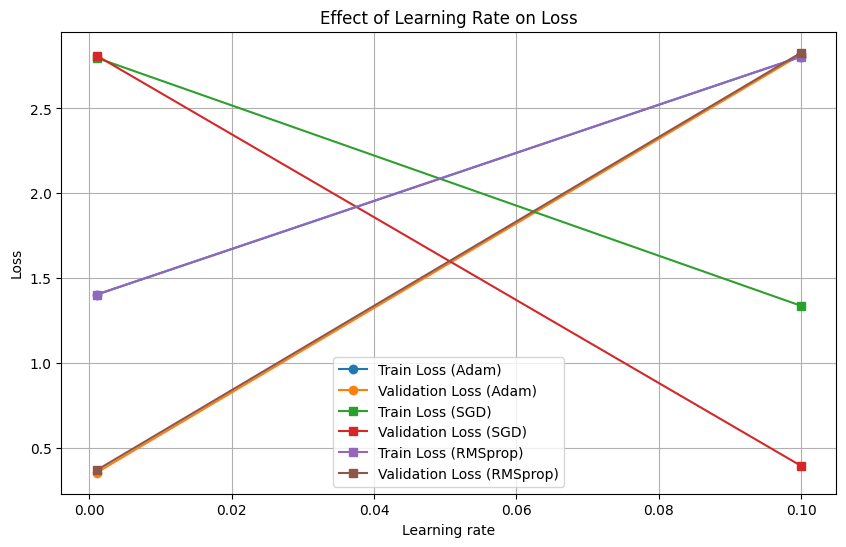

In [20]:
# Plot for ReLU
plt.figure(figsize=(10, 6))
plt.plot(learning_rate, train_losses_adam, marker='o', label="Train Loss (Adam)")
plt.plot(learning_rate, val_losses_adam, marker='o', label="Validation Loss (Adam)")

# Plot for Tanh
plt.plot(learning_rate, train_losses_sgd, marker='s', label="Train Loss (SGD)")
plt.plot(learning_rate, val_losses_sgd, marker='s', label="Validation Loss (SGD)")

# RMSprop
plt.plot(learning_rate, train_losses_rmsprop, marker='s', label="Train Loss (RMSprop)")
plt.plot(learning_rate, val_losses_rmsprop, marker='s', label="Validation Loss (RMSprop)")

# Labels and Title
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Effect of Learning Rate on Loss")
plt.legend()
plt.grid(True)
plt.show()

### Plot 5 - Loss against Decay Factor

In [ ]:
# Loss against decay factor

learning_rate_base = 0.005
batch_size_base = 64
activation_base = nn.ReLU()
dropout_rate_base = 0.2
no_epochs = 10
num_hidden_layers_base = 3
hidden_size_base = 512
decay_factor_base = np.linspace(0.1, 0.9, 30)

val_losses_decay = []
train_losses_decay = []



for decay_factor in decay_factor_base:
    val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(learning_rate_base, num_hidden_layers_base, hidden_size_base, batch_size_base, activation_base, dropout_rate_base, decay_factor, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', no_epochs)
    val_losses_decay.append(val_loss)
    train_losses_decay.append(train_loss)
    print(f"Decay Factor: {decay_factor}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(list(zip(decay_factor_base, val_losses_decay, train_losses_decay)), columns=["decay_factor", "val_loss", "train_loss"])
results_df.to_csv('decay_results.csv', index=False)


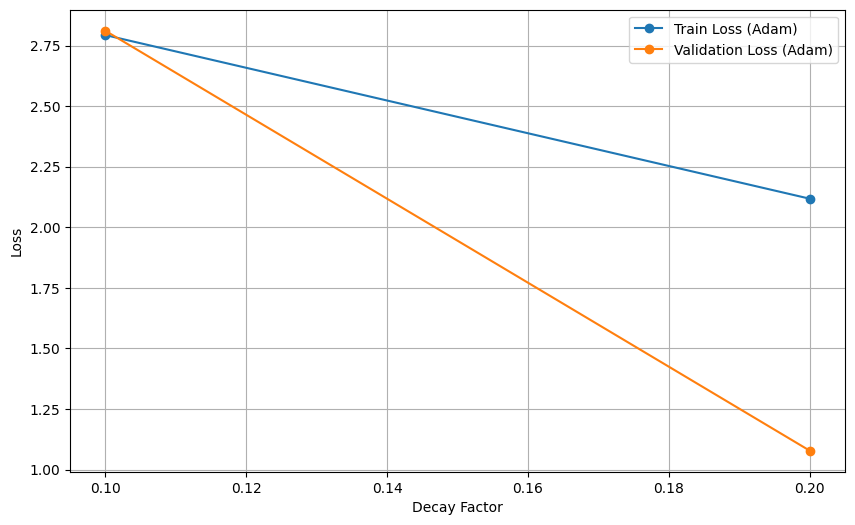

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(decay_factor_base, train_losses_decay, marker='o', label="Train Loss (Adam)")
plt.plot(decay_factor_base, val_losses_decay, marker='o', label="Validation Loss (Adam)")

# Labels and Title
plt.xlabel("Decay Factor")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Plot 6 - Confusion Matrix

In [28]:
_,_,_,_,_,_,_,_,_,_,cm1,cm2,_ = train_and_evaluate(0.0008, 3, 800, 64, nn.ReLU(), 0.2, 0.7, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'adam', 30)


cm = confusion_matrix(cm1, cm2)

print(classification_report(cm1, cm2))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=range(20), yticklabels=range(20))

# Add labels and title
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


KeyboardInterrupt: 

### Plot 7 - Batch Size against Learning Rate

In [26]:
# Batch size against learning rate

batch_size = [32, 64, 128, 256]
learning_rates = np.linspace(0.01, 0.5, 29)


activation_base = nn.ReLU()
dropout_rate_base = 0.2
no_epochs = 2
num_hidden_layers_base = 5
hidden_size_base = 512
decay_factor_base = 0.8


val_losses_bs_lr = []
train_losses_bs_lr = []

for batch in batch_size:
    for lr in learning_rates:
        val_loss, val_acc, test_loss, test_acc, train_loss, train_acc, train_list, val_list, train_acc_list, val_acc_list, _, _, model = train_and_evaluate(lr, num_hidden_layers_base, hidden_size_base, batch, activation_base, dropout_rate_base, decay_factor_base, combined_train_images, combined_train_labels, val_images, val_labels, test_images, test_labels, 'sgd', no_epochs)
        val_losses_bs_lr.append(val_loss)
        train_losses_bs_lr.append(train_loss)
        print(f"Batch Size: {batch}, Learning Rate: {lr}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

results_df = pd.DataFrame(list(zip(batch_size, learning_rates, val_losses_bs_lr, train_losses_bs_lr)), columns=["batch_size", "learning_rate", "val_loss", "train_loss"])
results_df.to_csv('bs_lr_results.csv', index=False)


Epoch 1/2
  Train Loss: 2.7300, Train Accuracy: 0.1040
  Val Loss: 2.3316, Val Accuracy: 0.1681
Epoch 2/2
  Train Loss: 2.4651, Train Accuracy: 0.1475
  Val Loss: 1.9204, Val Accuracy: 0.2838
Test Loss: 1.9168, Test Accuracy: 0.2866
Batch Size: 32, Learning Rate: 0.1, Val Loss: 1.9204, Val Acc: 0.2838, Test Loss: 1.9168, Test Acc: 0.2866
Epoch 1/2
  Train Loss: 2.6644, Train Accuracy: 0.1144
  Val Loss: 2.1132, Val Accuracy: 0.2098
Epoch 2/2
  Train Loss: 2.3495, Train Accuracy: 0.1955
  Val Loss: 1.4420, Val Accuracy: 0.5054
Test Loss: 1.4296, Test Accuracy: 0.5094
Batch Size: 32, Learning Rate: 0.2, Val Loss: 1.4420, Val Acc: 0.5054, Test Loss: 1.4296, Test Acc: 0.5094
Epoch 1/2
  Train Loss: 2.8020, Train Accuracy: 0.0976
  Val Loss: 2.7408, Val Accuracy: 0.1041
Epoch 2/2
  Train Loss: 2.6125, Train Accuracy: 0.1188
  Val Loss: 2.1946, Val Accuracy: 0.1871
Test Loss: 2.1896, Test Accuracy: 0.1879
Batch Size: 64, Learning Rate: 0.1, Val Loss: 2.1946, Val Acc: 0.1871, Test Loss: 2.189

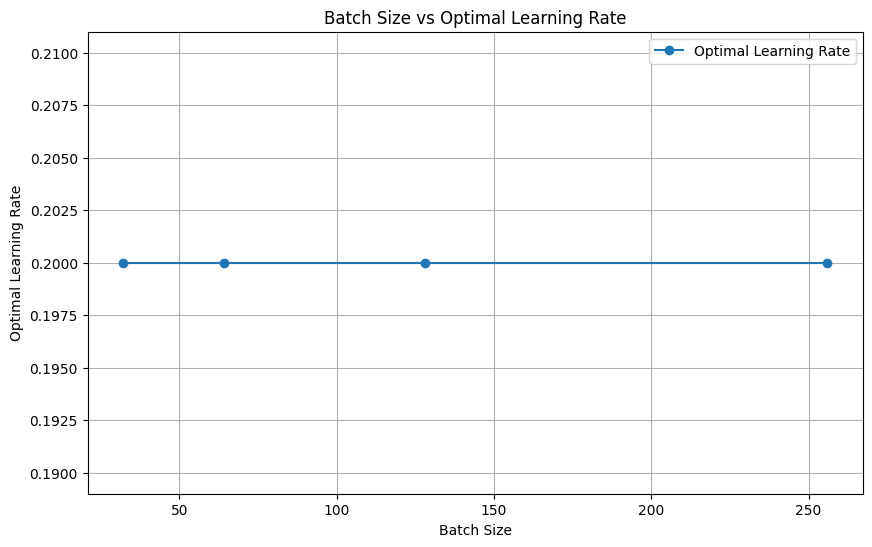

In [29]:
# Arrays to store the optimal learning rates
optimal_learning_rates = []
corresponding_batch_sizes = []

# Process validation losses to find optimal learning rates for each batch size
for i, batch in enumerate(batch_size):
    # Extract the validation losses for the current batch size
    batch_val_losses = val_losses_bs_lr[i * len(learning_rates):(i + 1) * len(learning_rates)]
    
    # Find the index of the minimum validation loss
    min_loss_index = np.argmin(batch_val_losses)
    
    # Store the optimal learning rate and corresponding batch size
    optimal_learning_rates.append(learning_rates[min_loss_index])
    corresponding_batch_sizes.append(batch)

# Plot the Batch Size vs Optimal Learning Rate
plt.figure(figsize=(10, 6))
plt.plot(corresponding_batch_sizes, optimal_learning_rates, marker='o', label='Optimal Learning Rate')
plt.xlabel("Batch Size")
plt.ylabel("Optimal Learning Rate")
plt.title("Batch Size vs Optimal Learning Rate")
plt.grid(True)
plt.legend()
plt.show()